In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import data

In [20]:
data = pd.read_csv("training_data.csv", dtype={"FIPS": str})
# data.shape   #(780203, 170)
data = data.drop_duplicates()
# data.shape #(779889, 165)
data

,MeasureId,Data_Value,FIPS,AREA_SQMI,EP_POV,EP_UNEMP,EP_PCI,EP_NOHSDP,EP_AGE65,EP_AGE17,...,Estimate!!Percent with a disability!!Subject!!DISABILITY TYPE BY DETAILED AGE!!With a self-care difficulty!!Population 65 years and over,Estimate!!Percent with a disability!!Subject!!DISABILITY TYPE BY DETAILED AGE!!With a self-care difficulty!!Population 65 years and over!!Population 65 to 74 years,Estimate!!Percent with a disability!!Subject!!DISABILITY TYPE BY DETAILED AGE!!With a self-care difficulty!!Population 65 years and over!!Population 75 years and over,Estimate!!Percent with a disability!!Subject!!DISABILITY TYPE BY DETAILED AGE!!With an independent living difficulty,Estimate!!Percent with a disability!!Subject!!DISABILITY TYPE BY DETAILED AGE!!With an independent living difficulty!!Population 18 to 64 years,Estimate!!Percent with a disability!!Subject!!DISABILITY TYPE BY DETAILED AGE!!With an independent living difficulty!!Population 18 to 64 years!!Population 18 to 34 years,Estimate!!Percent with a disability!!Subject!!DISABILITY TYPE BY DETAILED AGE!!With an independent living difficulty!!Population 18 to 64 years!!Population 35 to 64 years,Estimate!!Percent with a disability!!Subject!!DISABILITY TYPE BY DETAILED AGE!!With an independent living difficulty!!Population 65 years and over,Estimate!!Percent with a disability!!Subject!!DISABILITY TYPE BY DETAILED AGE!!With an independent living difficulty!!Population 65 years and over!!Population 65 to 74 years,Estimate!!Percent with a disability!!Subject!!DISABILITY TYPE BY DETAILED AGE!!With an independent living difficulty!!Population 65 years and over!!Population 75 years and over
0,ARTHRITIS,14.6,06037602504,0.124112,19.8,12.2,20350.0,17.5,5.4,25.6,...,12.3,11.2,14.0,4.1,3.1,2.3,4.0,17.3,11.2,26.0
1,ARTHRITIS,22.0,06065045213,1.135304,11.8,13.0,23655.0,21.5,12.2,28.5,...,10.3,6.1,24.1,3.8,2.1,2.5,1.9,11.4,3.1,38.5
2,DIABETES,12.7,06037601801,0.187925,35.2,14.7,11366.0,58.6,4.8,30.2,...,10.0,17.2,0.0,2.4,1.3,0.0,2.5,20.0,5.7,39.7
3,MAMMOUSE,81.9,01073014302,21.655658,11.1,3.4,42352.0,3.8,13.7,22.3,...,5.0,0.0,15.6,4.7,2.6,2.7,2.5,16.3,4.1,42.2
4,DIABETES,9.3,01089002922,2.566600,2.3,4.6,45980.0,1.5,18.2,18.5,...,6.7,3.5,9.9,4.8,2.5,5.5,1.7,11.4,4.2,18.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27570,PAPTEST,82.0,55101000400,0.681080,46.9,7.6,12359.0,33.5,5.9,37.3,...,8.1,7.7,8.8,8.5,7.4,1.8,10.7,20.0,15.5,29.4
27571,BINGE,25.3,55101000700,0.907844,8.7,2.7,22603.0,18.2,10.1,27.6,...,18.0,8.3,33.3,5.7,3.2,4.3,2.4,22.0,13.7,35.1
27572,DIABETES,9.1,56021000600,1.220468,8.3,3.4,29810.0,8.8,15.5,19.0,...,2.4,0.0,4.6,5.5,3.5,1.5,5.6,14.4,8.4,20.0
27573,LPA,23.7,55133202202,1.190032,17.8,4.0,26845.0,6.4,12.3,22.1,...,14.6,0.0,20.3,5.9,2.2,0.9,3.5,25.3,0.0,35.1


# Classifiers

## Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from joblib import dump, load

### Hyperparameters Tuning

In [ ]:
health = data[data['MeasureId']== 'ARTHRITIS'].dropna(subset=['Data_Value'])
measure_ids = ['ARTHRITIS']

n_splits = 10
scaler = StandardScaler()
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
num_trees = [1, 50, 100, 200]
test_accs = []


for measure in measure_ids:
    subdata = data[data['MeasureId'] == measure].dropna(subset=['Data_Value']).drop(columns='MeasureId')
    X = subdata.drop(columns=['Data_Value'])
    X = scaler.fit_transform(X)

    y = subdata['Data_Value']
    y, bins = pd.qcut(y, q=3, labels=range(3), retbins=True)


    m =  X.shape[1]
    max_features = [ m, m//2, 'sqrt']

    for features in max_features:
        test_acc = []
        for tree in num_trees:
            rf = RandomForestClassifier(n_estimators=tree, max_depth=10, max_features=features)
            cv_results = cross_validate(estimator=rf, X=X, y=y, scoring='accuracy', cv=skf)
            test_acc.append(np.mean(cv_results['test_score']))
            test_accs.append(test_acc)


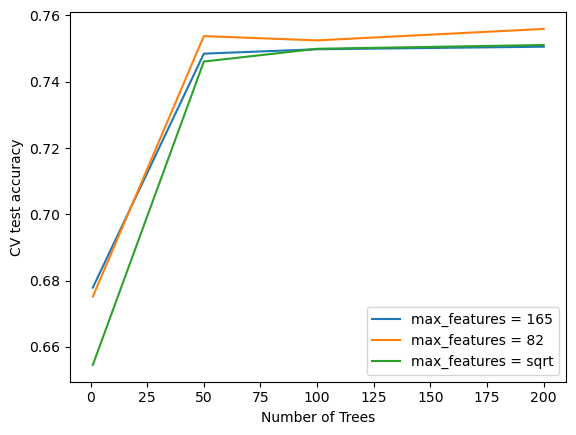

In [83]:
# Plot CV test accuracy vs number of trees 
# 3 bins | max_depth=10

# plt.xlabel('Number of Trees')
# plt.ylabel('CV test accuracy')
# for i, max_feat in enumerate(max_features):
#     plt.plot(num_trees, test_accs[i] , label="max_features = "+str(max_feat))
# plt.legend(loc="lower right")

# plt.show()

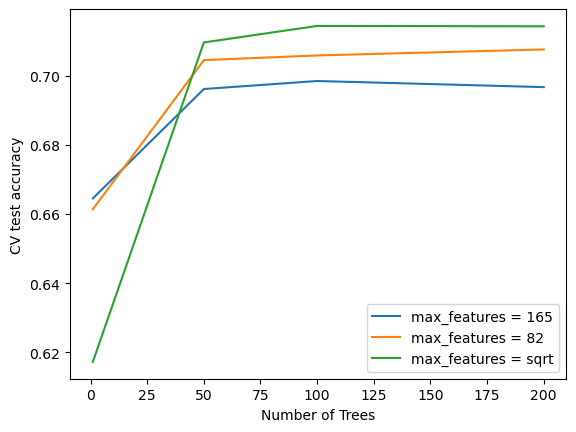

In [80]:
# Plot CV test accuracy vs number of trees 
# 3 bins | max_depth=5

# plt.xlabel('Number of Trees')
# plt.ylabel('CV test accuracy')
# for i, max_feat in enumerate(max_features):
#     plt.plot(num_trees, test_accs[i] , label="max_features = "+str(max_feat))
# plt.legend(loc="lower right")

# plt.show()

### Main Training 

In [24]:
for measure in data.columns:
    if data[measure].hasnans:
        print(measure)

Data_Value


In [27]:
measure_ids = list(data['MeasureId'].unique())
# measure_ids = ['DENTAL']
num_bins = ["2-bin", "3-bin", "4-bin"]
randomfroest = pd.DataFrame(index=measure_ids, columns=['accuracy'])
report = {}

n_splits = 10
scaler = StandardScaler()
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
tree = 50

# for bin in num_bins:
for measure in measure_ids:
    subdata = data[data['MeasureId'] == measure].dropna(subset=['Data_Value']).drop(columns=['MeasureId', 'FIPS'])
    X = subdata.drop(columns=['Data_Value'])
    X = scaler.fit_transform(X)
    feature = X.shape[1] // 2


    y = subdata['Data_Value']
    y, bins = pd.qcut(y, q=3, labels=range(3), retbins=True)

    # measure_desc = y.describe()
    # bin_edges = [measure_desc[3], measure_desc[4], measure_desc[6], measure_desc[7]]
    # bin_labels = ['low', 'medium', 'high']
    # y_binned = pd.cut(y, bins=bin_edges, labels=bin_labels, include_lowest=True)

    rf = RandomForestClassifier(n_estimators=tree, max_depth=10, max_features=feature)
    rf.fit(X, y)

    ## Only accuracy
    # cv_results = cross_validate(estimator=rf, X=X, y=y, scoring='accuracy', cv=skf)

    ## F1 score
    # y_pred = cross_val_predict(rf, X, y, cv=skf)
    # report[measure] = classification_report(y_binned, y_pred, digits=3, output_dict=True)

    dump(rf, 'Models/'+ measure+'.joblib') 
    print("done " + measure)

# randomfroest = randomfroest.astype('float').round(3)

done ARTHRITIS
done DIABETES
done MAMMOUSE
done OBESITY
done STROKE
done BPHIGH
done TEETHLOST
done CSMOKING
done BINGE
done CHOLSCREEN
done CHD
done CHECKUP
done CASTHMA
done KIDNEY
done SLEEP
done PAPTEST
done COPD
done LPA
done MHLTH
done PHLTH
done COREM
done DENTAL
done HIGHCHOL
done ACCESS2
done BPMED
done COLON_SCREEN
done COREW
done CANCER


### Results Analysis

In [133]:
report

{'ARTHRITIS': {'high': {'precision': 0.8190800681431005,
   'recall': 0.7120853080568721,
   'f1-score': 0.7618443986689907,
   'support': 6752.0},
  'low': {'precision': 0.8319830926382529,
   'recall': 0.6931768158473954,
   'f1-score': 0.7562635075642359,
   'support': 6815.0},
  'medium': {'precision': 0.7458958799105717,
   'recall': 0.8563361689645057,
   'f1-score': 0.7973097538493052,
   'support': 13636.0},
  'accuracy': 0.7796566555159358,
  'macro avg': {'precision': 0.7989863468973084,
   'recall': 0.7538660976229243,
   'f1-score': 0.7718058866941773,
   'support': 27203.0},
  'weighted avg': {'precision': 0.7856276739658296,
   'recall': 0.7796566555159358,
   'f1-score': 0.7782239086627364,
   'support': 27203.0}},
 'CHD': {'high': {'precision': 0.8309630963096309,
   'recall': 0.7008806559368357,
   'f1-score': 0.7603986492051725,
   'support': 6586.0},
  'low': {'precision': 0.8649973734897566,
   'recall': 0.7099741304972693,
   'f1-score': 0.7798563422527428,
   'sup

In [ ]:
outcome = {'Health Outcomes': ['ARTHRITIS',
  'CHD',
  'COPD',
  'DIABETES',
  'TEETHLOST',
  'CASTHMA',
  'KIDNEY',
  'STROKE',
  'BPHIGH',
  'CANCER',
  'PHLTH',
  'MHLTH',
  'HIGHCHOL'],
 'Unhealthy Behaviors': ['CSMOKING', 'OBESITY', 'BINGE', 'LPA', 'SLEEP'],
 'Prevention': ['CHOLSCREEN',
  'MAMMOUSE',
  'ACCESS2',
  'DENTAL',
  'CHECKUP',
  'PAPTEST',
  'COREM',
  'BPMED',
  'COLON_SCREEN',
  'COREW']}

In [ ]:
measures = randomfroest.index.values

health = []
behavior = []
prevention = []
for measure in measures:
    if measure in outcome['Health Outcomes']:
        health.append(randomfroest.loc[measure, 'accuracy'])
    elif measure in outcome['Unhealthy Behaviors']:
        behavior.append(randomfroest.loc[measure, 'accuracy'])
    elif measure in outcome['Prevention']:
        prevention.append(randomfroest.loc[measure, 'accuracy'])
    else:
        print('eeror', measure)

randomfroest.loc['Health Outcomes', 'accuracy'] = round(np.mean(health), 3)
randomfroest.loc['Unhealthy Behaviors', 'accuracy'] = round(np.mean(behavior), 3)
randomfroest.loc['Prevention', 'accuracy'] = round(np.mean(prevention), 3)

randomfroest.to_csv('Results/newRandomForest.csv') 

In [142]:
randomfroest

,accuracy
ARTHRITIS,0.779657
CHD,0.792682
KIDNEY,0.824745
SLEEP,0.813617
COPD,0.793199
BPHIGH,0.782287
OBESITY,0.8464
DENTAL,0.869201
PHLTH,0.835019
COREW,0.811822


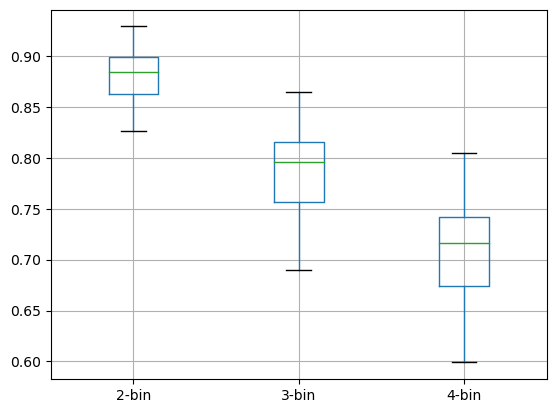

In [55]:
box = randomfroest.drop(index=['Health Outcomes', 'Unhealthy Behaviors', 'Prevention', 'Average'])
boxplot = box.boxplot()

## MLPClassifier

In [104]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [ ]:
measure_ids = list(data['MeasureId'].unique())

mlp = pd.DataFrame(index=measure_ids, columns=num_bins)

mlp_report = {}

# for bin in num_bins:
for measure in measure_ids:
    subdata = data[data['MeasureId'] == measure].dropna(subset=['Data_Value']).drop(columns='MeasureId')
    
    X = subdata.drop(columns=['Data_Value'])
    X = scaler.fit_transform(X)

    y = subdata['Data_Value']
    y, bins = pd.qcut(y, q=3, labels=range(3), retbins=True)

    X_train, X_test, y_train, y_test = train_test_split (X,y, test_size = 0.3, random_state = 0)

    mlp_gs = MLPClassifier(activation= 'relu', alpha = 0.5, hidden_layer_sizes = (3,5,3), learning_rate = 'adaptive', solver= 'sgd')
    ## Grid Search
    # parameter_space = {
    # 'hidden_layer_sizes': [(3,5,5,3), (5,10,5)] # (10,30,10), (5), (50), (100), (20, 50, 20) ,(64,25,11,7,3)
    # 'activation': ['tanh', 'relu'],
    # 'solver': ['sgd', 'lbfgs', 'adam'],
    # 'alpha': [0.001, 0.01, 0.05, 0.1, 1],
    # 'learning_rate': ['constant','adaptive'],
    # }
    # clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
    # clf.fit(X, y) # X is train samples and y is the corresponding labels


    y_pred = cross_val_predict(mlp_gs, X, y, cv=5)
    mlp_report[measure] = classification_report(y, y_pred, digits=3, output_dict=True)
    
    # mlp_gs.fit(X_train, y_train)

    mlp.loc[measure] = round(mlp_report[measure]['accuracy'],3)
    
    # dump(mlp_gs, 'Models/'+measure+'.joblib') 


    print("done " + measure)

In [ ]:

health = []
behavior = []
prevention = []
for measure in measure_ids:
    if measure in outcome['Health Outcomes']:
        health.append(mlp.loc[measure, "3-bin"])
    elif measure in outcome['Unhealthy Behaviors']:
        behavior.append(mlp.loc[measure, "3-bin"])
    elif measure in outcome['Prevention']:
        prevention.append(mlp.loc[measure, "3-bin"])
    else:
        print('eeror', measure)
    
    mlp.loc['Health Outcomes', "3-bin"] = round(np.mean(health), 3)
    mlp.loc['Unhealthy Behaviors', "3-bin"] = round(np.mean(behavior), 3)
    mlp.loc['Prevention', "3-bin"] = round(np.mean(prevention), 3)

In [115]:
mlp_report

{'ARTHRITIS': {'0': {'precision': 0.8187709497206704,
   'recall': 0.8006118212607888,
   'f1-score': 0.809589570789372,
   'support': 9153.0},
  '1': {'precision': 0.6400085306035402,
   'recall': 0.6569614711033275,
   'f1-score': 0.6483742033056066,
   'support': 9136.0},
  '2': {'precision': 0.8084507042253521,
   'recall': 0.8049136190262508,
   'f1-score': 0.8066782843330148,
   'support': 8914.0},
  'accuracy': 0.7537771569312208,
  'macro avg': {'precision': 0.7557433948498543,
   'recall': 0.7541623037967891,
   'f1-score': 0.7548806861426645,
   'support': 27203.0},
  'weighted avg': {'precision': 0.7553526455115991,
   'recall': 0.7537771569312208,
   'f1-score': 0.7544921622387104,
   'support': 27203.0}},
 'CHD': {'0': {'precision': 0.8284847804110974,
   'recall': 0.793886556883005,
   'f1-score': 0.8108167527756402,
   'support': 9291.0},
  '1': {'precision': 0.6265227295236209,
   'recall': 0.6817544994072637,
   'f1-score': 0.6529727497935591,
   'support': 9279.0},
  

In [113]:
mlp.to_csv('Results/MLP.csv') 

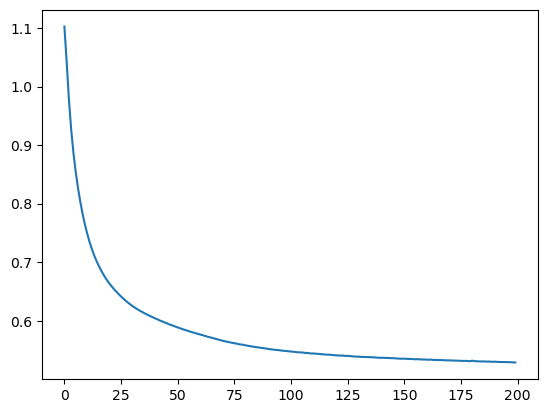

In [95]:
plt.plot(range(len(mlp_gs.loss_curve_)), mlp_gs.loss_curve_)

In [96]:
mlp_gs.score(X_test, y_test)

0.7794387942654086

In [89]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'hidden_layer_sizes': (3, 5, 5, 3)}


In [ ]:
clf.cv_results_

{'mean_fit_time': array([21.51923637, 23.03638425, 20.75202475, 23.1262979 , 14.34542913,
        16.28896618, 14.81175056, 16.26607485, 20.78822899, 22.28387723,
        20.9317215 , 24.56510959, 14.78427029, 15.67478952, 16.08077016,
        17.70065508, 23.70131779, 25.54761047, 21.2231185 , 24.64232984,
        14.83503542, 16.55762858, 15.18707891, 16.47631235, 21.33918152,
        23.77440648, 20.46596227, 24.06906748, 14.74527659, 16.50027895,
        14.43774705, 14.09600468]),
 'std_fit_time': array([0.9079714 , 0.70688901, 0.94625356, 0.87984185, 0.62417894,
        0.56666398, 0.85971252, 0.73126152, 0.9020842 , 0.88667464,
        0.57551769, 0.77050193, 1.39554914, 0.60102152, 0.97116836,
        1.20490508, 1.16028814, 2.23960934, 1.52368145, 1.22104233,
        0.33073199, 0.41190449, 0.38470551, 0.69751612, 1.12586715,
        0.98499942, 0.78855305, 0.85659345, 0.77927994, 0.67500747,
        0.8750371 , 0.59654575]),
 'mean_score_time': array([0.00732236, 0.00718899, 

## HistGradientBoostingClassifier

In [116]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [118]:
measure_ids = list(data['MeasureId'].unique())
hgbc = pd.DataFrame(index=measure_ids, columns=['accuracy'])
report = {}
scaler = StandardScaler()

# for bin in num_bins:
for measure in measure_ids:
    subdata = data[data['MeasureId'] == measure].dropna(subset=['Data_Value']).drop(columns='MeasureId')

    X = subdata.drop(columns=['Data_Value'])
    X = scaler.fit_transform(X)

    y = subdata['Data_Value']
    y, bins = pd.qcut(y, q=3, labels=range(3), retbins=True)

    clf = HistGradientBoostingClassifier()
    cv_results = cross_validate(estimator=clf, X=X, y=y, scoring='accuracy', cv=10)
    # # cv_results = cross_validate(estimator=rf, X=X, y=y, scoring='accuracy', cv=skf)
    # y_pred = cross_val_predict(rf, X, y, cv=skf)
    # report[measure] = classification_report(y, y_pred, digits=3, output_dict=True)
    
    hgbc.loc[measure, 'accuracy'] = np.mean(cv_results['test_score'])

    print("done " + measure )#+ randomfroest.loc[measure, 'accuracy'])
    # print(report[measure])

hgbc = hgbc.astype('float').round(3)

done ARTHRITIS


In [121]:
hgbc

,accuracy
ARTHRITIS,0.653


In [120]:
cv_results

{'fit_time': array([7.94417644, 7.33483601, 8.5481267 , 7.70439506, 6.00736523,
        6.57551885, 5.56555438, 3.97410989, 5.10831785, 4.99644923]),
 'score_time': array([0.03565478, 0.03191042, 0.03654671, 0.02432227, 0.03370547,
        0.03287339, 0.02433538, 0.01932716, 0.02451539, 0.0220952 ]),
 'test_score': array([0.77692025, 0.62330026, 0.65747887, 0.57720588, 0.54117647,
        0.53860294, 0.625     , 0.71654412, 0.75257353, 0.725     ])}

# Predicting

In [36]:
test_data =  pd.read_csv("testing_data.csv", dtype={'FIPS': str})
test_data['State'] = test_data['FIPS'].apply(lambda x: x[:2])
test_data['County'] = test_data['FIPS'].apply(lambda x: x[:5])

In [43]:
test_data_MN = test_data.loc[test_data['State'] == "27"]

# for c in test_data_MN.columns:
#     if test_data_MN[c].hasnans:
#         print(c)

In [45]:
rf = load("Models/DENTAL.joblib")
X = scaler.fit_transform(test_data_MN.drop(columns=['FIPS', 'State', 'County']))
predictions = rf.predict(X)

MN_output is at city level

In [48]:
MN_output = test_data_MN[['FIPS', 'State', 'County']]
MN_output['level'] = predictions
MN_output

/tmp/ipykernel_417326/216793694.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MN_output['level'] = predictions


,FIPS,State,County,level
22705,27003050234,27,27003,1
22706,27003050402,27,27003,1
22707,27003050605,27,27003,1
22755,27003050610,27,27003,1
22756,27003050702,27,27003,1
...,...,...,...,...
71930,27053125600,27,27053,1
71931,27095970200,27,27095,0
71932,27115950200,27,27115,0
71933,27141030503,27,27141,1


MN_final_output is at 'county' level applying majority vote

In [50]:
vote = MN_output.groupby('County')['level'].value_counts()
MN_final_output = MN_output[['County']].drop_duplicates()
MN_final_output['prediction'] = vote.agg(lambda s: s.value_counts().index[0])

In [51]:
vote

County  level
27001   0         3
        1         3
27003   1        49
        2        22
        0        12
                 ..
27169   1         6
        0         4
27171   1        16
        2         1
27173   1         4
Name: count, Length: 166, dtype: int64

In [52]:
MN_final_output

,County,prediction
22705,27003,1
22761,27005,1
22762,27007,1
22763,27009,1
22784,27011,1
...,...,...
30518,27063,1
30746,27083,1
31450,27155,1
31452,27159,1
